**IMPLEMENTING GENERATIVE ADVERSARIAL NETS**

**IMPORTING THE NECESSARY LIBRARIES**

In [1]:
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
import torchvision.utils as vutils

**DEFINE THE HYPERPARAMETERS**

The input is a 3x64x64 input image and the output is a scalar probability that the input is from the real data distribution

In [2]:
img_size = 64
n_epochs = 24
batch_size = 64
learning_rate = 0.0002


**FOR OUR MODEL WE WILL USE THE CIFAR-10 DATASET**

In [3]:
transform = transforms.Compose([transforms.Scale(img_size),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = torch.utils.data.DataLoader(dset.CIFAR10('fashion', train = True,download = True, transform = transform),
    batch_size = batch_size,shuffle = True, num_workers = 2)

#Labels of Cifar-10 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
device =  torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified


Now, we can create the dataset, create the dataloader, set the device to run on, and finally visualize some of the training data.

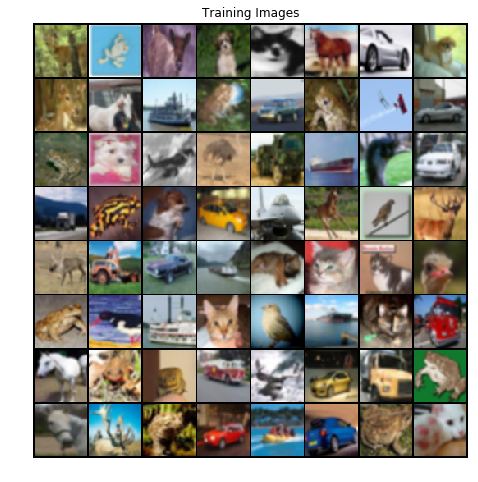

In [4]:
# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

nz - length of latent vector <br>
ngf - relates to the depth of feature maps carried through the generator <br>
ndf - sets the depth of feature maps propagated through the discriminator <br>
nc - number of color channels in the input images. For color images this is 3

In [5]:
nz = 100
ngf = 64
nc = 3
ndf = 64

The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [6]:
def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

We set in the input section (nz, ngf, and nc) influence the generator architecture in code. nz is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images)

In [7]:
class Generator(nn.Module):
    def __init__(self,nc=3, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
    def forward(self, input):
        output = self.main(input)
        return output


Check out the printed model to see how the generator object is structured.

In [8]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


The discriminator, D, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). Here, D takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. 

In [9]:
class Discriminator(nn.Module):
    def __init__(self,nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

Now, as with the generator, we can create the discriminator, apply the weights_init function, and print the model’s structure.

In [10]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


We will use the Binary Cross Entropy loss (BCELoss) function 

In [11]:
lr = 0.0002
beta1 = 0.5
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


Training: <br> Part 1: Train the discriminator <br> Part 2: Train the Generator <br> at the end of each epoch we will push our fixed_noise batch through the generator to visually track the progress of G’s training

In [13]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 15
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 100 == 0:
            print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs,errD.item(), errG.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/15]	Loss_D: 1.2039	Loss_G: 2.6543	
[0/15]	Loss_D: 0.3063	Loss_G: 2.2724	
[0/15]	Loss_D: 0.7066	Loss_G: 4.3593	
[0/15]	Loss_D: 0.2296	Loss_G: 3.1738	
[0/15]	Loss_D: 0.2699	Loss_G: 4.5015	
[0/15]	Loss_D: 0.2056	Loss_G: 3.2946	
[0/15]	Loss_D: 0.3535	Loss_G: 2.6813	
[0/15]	Loss_D: 2.2366	Loss_G: 8.8061	
[1/15]	Loss_D: 0.6855	Loss_G: 1.9945	
[1/15]	Loss_D: 0.5036	Loss_G: 5.4225	
[1/15]	Loss_D: 0.9337	Loss_G: 1.1083	
[1/15]	Loss_D: 0.7508	Loss_G: 6.7303	
[1/15]	Loss_D: 0.5121	Loss_G: 3.5334	
[1/15]	Loss_D: 0.0947	Loss_G: 3.7357	
[1/15]	Loss_D: 1.1840	Loss_G: 1.5076	
[1/15]	Loss_D: 0.4943	Loss_G: 4.1287	
[2/15]	Loss_D: 0.0166	Loss_G: 5.3777	
[2/15]	Loss_D: 0.2192	Loss_G: 3.5430	
[2/15]	Loss_D: 0.5763	Loss_G: 1.7159	
[2/15]	Loss_D: 0.1814	Loss_G: 3.9635	
[2/15]	Loss_D: 0.2971	Loss_G: 3.4713	
[2/15]	Loss_D: 0.0877	Loss_G: 3.9194	
[2/15]	Loss_D: 0.7259	Loss_G: 3.8563	
[2/15]	Loss_D: 0.0510	Loss_G: 4.0699	
[3/15]	Loss_D: 0.4860	Loss_G: 3.6004	
[3/15]	Loss_D: 0.4034	Lo

First, we will see how D and G’s losses changed during training. Second, we will visualize G’s output on the fixed_noise batch for every epoch. And third, we will look at a batch of real data next to a batch of fake data from G.

**Loss versus training iteration**



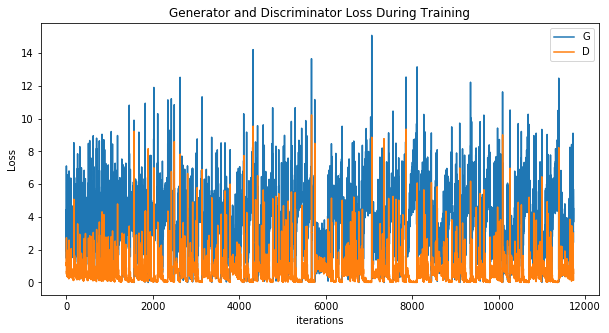

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

 we can visualize the training progression of G

Fake Image:


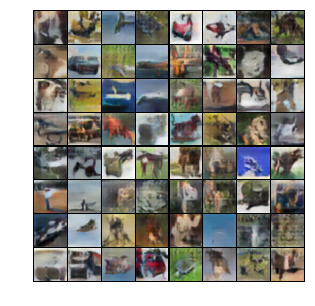

In [27]:
import numpy as np
fig = plt.figure(figsize=(5,5))
plt.axis("off")
print('Fake Image:')
ims = [[plt.imshow(np.transpose(i,(1,2,0)))] for i in img_list]